[Kaggle Competition](https://www.kaggle.com/c/nfl-big-data-bowl-2021)

Purpose of this notebook is to generate prediction models for the coverage type, based on 2018 week 1 labels provided in the competition.

Reason behind building a coverage label prediction model is to label plays for all other weeks (2-17) and then use that as an additional feature of downstream analytics, either at the play-level or tracking data within plays of a specific coverage type.

# Imports

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

In [3]:
# add local directory to import path
import os
import sys
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import nflutil

Loading the data:

In [4]:
week_num = 1

track_df = pd.read_csv(f'csv/week{week_num}.csv')
play_df = pd.read_csv('csv/plays.csv')
game_df = pd.read_csv('csv/games.csv')
player_df = pd.read_csv('csv/players.csv')
coverage_df = pd.read_csv('csv/coverages_week1.csv')

# Generate Features

Features are generated on a per-play basis to predict the overall defensive coverage scheme.

Unless specified as the value at a particular stage of the play (snap, throw, etc.), the features are calculated at each time step between the snap and a "pivot" event that will alter the behavior of the defense (i.e. throw or sack) or a maximum elapsed time after the snap, whichever is first. The maximum time is meant to limit the effect of the play breaking down on the planned movements of the players.

All defenders are evaluated at a threshold time in the play (e.g. 1.5 seconds after snap) if they are still beyond the line of scrimmage to determine which defenders are actually in coverage vs. blitzing. Blitzing player values would skew average results, and the movement of the rusher does not matter beyond the fact that they are not in coverage.

The following features are generated at a per-defender level (inspired by [this paper](https://arxiv.org/abs/1906.11373)), then averaged across all coverage defenders:

* **depth_mean**: average yards downfield of the defender (same as X_mean but normalizes for line of scrimmage)
* **depth_var**: variance in downfield movement (same as X_var, lower value expected for zone)
* **y_mean**: average horizontal location of defender
* **y_var**: variance in horizontal movement (lower value expected for zone)
* **speed_mean**: average speed of the defender, yd/sec (lower value expected for zone)
* **speed_var**: variance in speed of the defender (lower expected for zone)
* **off_mean**: average distance to the closest offensive player at each frame during a play (lower expected for man)
* **off_var**: variance in distance to the closest offensive player at each frame (lower expected for man)
* **def_mean**: average distance to the closest defender at each frame
* **def_var**: variance in distance to the closest defender at each frame
* **rat_mean**: see paper for better description
* **rat_var**: see paper for better description

New features: 

* **rat_o_los**: ratio of time during a play that a defender is facing the QB/line of scrimmage. Expected to be near 1 for zone (reading the QB's eyes, keeping receivers in front of them vs. turning and running with the receiver) **Current threshold is 60 degrees (240-300 deg) to account for man coverage following crossing routes or moving mostly sideways but slightly towards the LOS**

The following play-level features are generated:

* **n_cover**: the number of defenders with tracking data in coverage (beyond the LOS at t_defender_thresh sec)
* **n_cb**: the number of cornerbacks in the defensive formation
* **n_def_excess**: the number of coverage defenders minus eligible receivers (players available for zone or double coverage)

The following features are evaluated based on player locations at the snap (leverage info when defense do not disguise coverage pre-snap):
* **n_deep_snap**: the number of defenders over 10 yards downfield at the snap
* **cb_depth_snap_min**: depth of closest CB to the LOS (press vs. soft)
* **cb_depth_snap_mean**: average depth of CBs
* **cb_depth_snap_max**: depth of farther CB to the LOS (zone expected for far off the ball)

The following features are evaluated at the "freeze" time (determining which players are in coverage, coverage scheme is assumed to be materialized regardless if it was being disguised pre-snap or not):
* **n_deep_frz**: number of defenders over 10 yards downfield at "freeze"
* **def_spac_frz_avg**: spacing to nearest defender at "freeze", averaged over all coverage players
* **def_spac_frz_min**: same source as above, but minimum (larger expected for zone)
* **def_spac_frz_max**: same source as above, but maximum (smaller expected for zone)
* **cb_depth_frz_min**: same as at snap but at the "freeze" time
* **cb_depth_frz_mean**: same as at snap but at the "freeze" time
* **cb_depth_frz_max**: same as at snap but at the "freeze" time

In [5]:
def create_play_features(play_track_df, game_df, play_df, t_defender_thresh=1.5, t_scheme_develop=4, t_reaction_time=0):
    ### THE INPUT TRACKING DATA MUST BE NORMALIZED FOR DIRECTION BEFORE INPUT INTO THIS FUNCTION
    # inputs:
    #     - play_track_df: DataFrame of the raw player tracking data for an individual play.
    #                      MUST ONLY BE FOR A SINGLE PLAY, CANNOT HANDLE MULTIPLE PLAYS.
    #     - t_defender_thresh: time in seconds after the snap to determine which players are in coverage
    #     - t_scheme_develop: time in seconds after the snap to set as a max time threshold
    #                         (i.e. before the play breaks down, after which the movement 
    #                          is not always indicative of the coverage scheme)
    #     - t_reaction_time: time in seconds after the ball thrown to continue taking statistics (paths
    #                        won't change until players realize the ball has been thrown)
    
    # local constants
    DEF_DEEP_THRESH = 10  # yards behind the line of scrimmage considered "deep" coverage

    # work on a copy of the data rather than the actual data (for temporary features)
    play_track_df = play_track_df.copy().drop_duplicates()
    
    # get the current play gameId and playId
    game_id = play_track_df.gameId.iloc[0]
    play_id = play_track_df.playId.iloc[0]
    
    # determine who has the ball (team code)
    home_abbr = game_df[game_df.gameId==game_id].iloc[0]['homeTeamAbbr']
    away_abbr = game_df[game_df.gameId==game_id].iloc[0]['visitorTeamAbbr']

    
    abbr_possess = play_df[(play_df.gameId==game_id) & (play_df.playId==play_id)].iloc[0]['possessionTeam']
    
    if abbr_possess == home_abbr:
        team_poss = 'home'
        team_def = 'away'
    else:
        team_poss = 'away'
        team_def = 'home'
        
 
    # ------------- FEATURE GENERATION SETUP/INTERMEDIATE CALCULATIONS ----------------------
     
    # get play information
    x_los = play_track_df.x[(play_track_df.team == 'football') & (play_track_df.frameId == 1)].iloc[0]
    
    # save the distance downfield of all observations relative to the line of scrimmage
    play_track_df['depth'] = play_track_df['x'] - x_los
    
    # get frameId for specific points in the play (exclude handoff: not a material pivot part of the play,
    # also sometimes occurs prior to the snap)
    pivot_events = ['pass_forward', 'qb_sack', 'fumble', 'qb_strip_sack', 'pass_shovel']
    
    frame_max = play_track_df.frameId.max()
    frame_snap = play_track_df[play_track_df.event=='ball_snap']['frameId'].iloc[0]
    if np.any(play_track_df.event.isin(pivot_events)):
        # find the frameId of the earliest of the pivot events
        # - account for errors on individual players: group by event, find the median frame for each event, then
        #   take the minimum of the medians to get the first event (essentially voting then min)
        frame_pivot = (play_track_df.loc[play_track_df.event.isin(pivot_events), ['event', 'frameId']]
                       .groupby('event').median().min().iloc[0]
                       + int(round(10 * t_reaction_time)))
    else:
        frame_pivot = frame_max
    
    # save important frameId's in the play:
    frame_start = frame_snap
    frame_cover_freeze = min(frame_max, frame_pivot, int(round(frame_snap + 10*t_defender_thresh)))
    frame_scheme_develop = int(frame_snap + round(10*t_scheme_develop))
    frame_end = min(frame_pivot, frame_scheme_develop, frame_max)
    
    
    # filter out data from frames outside of the range (frame_start <= F <= frame_end)
    play_track_df = play_track_df[(play_track_df.frameId >= frame_start) & (play_track_df.frameId <= frame_end)]
    
    
    # ----- SAVE SLICES OF DATAFRAME FOR DEFENDERS AND COVERAGE AND ELIGIBLE RECEIVERS ----
    
    ### get defensive player tracks that are in coverage (i.e. not blitzing/rushing the passer)
    cover_players = play_track_df.nflId[(play_track_df.frameId == frame_cover_freeze) &
                          (play_track_df.team == team_def) & 
                          (play_track_df.depth > 0)]
    def_track = play_track_df[play_track_df.nflId.isin(cover_players)].pivot(
        index='frameId', columns='nflId', values=['x', 'depth', 'y', 's', 'a', 'dir', 'o'])
    
    ### get offensive player tracks of eligible receivers (minus QB)
    # all players
    off_track = play_track_df[(play_track_df.team == team_poss) & (play_track_df.position != 'QB')].pivot(
        index='frameId', columns='nflId', values=['x', 'depth', 'y', 's', 'a', 'dir', 'o'])
    
    # players downfield (depth > 0)
    downfield_players = play_track_df.nflId[(play_track_df.frameId == frame_cover_freeze) &
                          (play_track_df.team == team_poss) & 
                          (play_track_df.depth > 0)]
    # edge case where there are no downfield receivers at the time of throw: quick screen,
    # goal-line, etc. --> classify all offensive players as "downfield"
    if len(downfield_players) == 0:
        downfield_players = play_track_df.nflId[(play_track_df.frameId == frame_cover_freeze) &
                          (play_track_df.team == team_poss) &
                          (play_track_df.position != 'QB')]
    
    downfield_track = play_track_df[play_track_df.nflId.isin(downfield_players)].pivot(
        index='frameId', columns='nflId', values=['x', 'depth', 'y', 's', 'a', 'dir', 'o'])
    
    # ----- OUTERMOST OFF-DEF MATCHUP FEATURES --------------------------------------------------------
    
    # get attributes for the outermost receivers and defenders at the snap to identify 
    # coverage as inside or outside technique
    
    # identify outermost defenders at snap (get corresponding array column index)
    min_def_y_idx = play_track_df.loc[(play_track_df.frameId == frame_snap) &
                              (play_track_df.team == team_def), 'y'].idxmin()
    max_def_y_idx = play_track_df.loc[(play_track_df.frameId == frame_snap) &
                              (play_track_df.team == team_def), 'y'].idxmax()
    right_def_nfl_id = play_track_df.nflId.loc[min_def_y_idx]
    left_def_nfl_id = play_track_df.nflId.loc[max_def_y_idx]
    
    # get outermost defender at snap X- and Y-coordinates during the play
    outer_def_x = np.hstack([play_track_df.x[play_track_df.nflId == left_def_nfl_id].to_numpy().reshape(-1,1),
                            play_track_df.x[play_track_df.nflId == right_def_nfl_id].to_numpy().reshape(-1,1)])
    outer_def_y = np.hstack([play_track_df.y[play_track_df.nflId == left_def_nfl_id].to_numpy().reshape(-1,1),
                            play_track_df.y[play_track_df.nflId == right_def_nfl_id].to_numpy().reshape(-1,1)])
    
    # identify outermost receivers at snap (get corresponding array column index)
    min_off_y_idx = play_track_df.loc[(play_track_df.frameId == frame_snap) &
                              (play_track_df.team == team_poss), 'y'].idxmin()
    max_off_y_idx = play_track_df.loc[(play_track_df.frameId == frame_snap) &
                              (play_track_df.team == team_poss), 'y'].idxmax()
    right_off_nfl_id = play_track_df.nflId.loc[min_off_y_idx]
    left_off_nfl_id = play_track_df.nflId.loc[max_off_y_idx]
    
    # get outermost receiver at snap X- and Y-coordinates during the play
    outer_off_x = np.hstack([play_track_df.x[play_track_df.nflId == left_off_nfl_id].to_numpy().reshape(-1,1),
                            play_track_df.x[play_track_df.nflId == right_off_nfl_id].to_numpy().reshape(-1,1)])
    outer_off_y = np.hstack([play_track_df.y[play_track_df.nflId == left_off_nfl_id].to_numpy().reshape(-1,1),
                            play_track_df.y[play_track_df.nflId == right_off_nfl_id].to_numpy().reshape(-1,1)])
    outer_off_dis = np.hstack([play_track_df.dis[play_track_df.nflId == left_off_nfl_id].to_numpy().reshape(-1,1),
                            play_track_df.dis[play_track_df.nflId == right_off_nfl_id].to_numpy().reshape(-1,1)])
    
    # -- Determine if the defender shadows outside or inside of the outer receiver:
    # -- inner likely man, outer likely zone. look at snap and aggregate until throw
    
    # distance from the middle of the field 
    dist_def_mid = np.abs(53.3/2 - outer_def_y)
    dist_off_mid = np.abs(53.3/2 - outer_off_y)
    # def - off: positive if defender is outside, negative if defender is inside
    dist_shadow_out = dist_def_mid - dist_off_mid

    # aggregate over play (mean offset inside or outside)
    dist_shadow_out_play = np.nanmean(dist_shadow_out, axis=0)
    
    # ------ PLAY CHARACTERISTICS AT SPECIFIC FRAMES/POINTS IN TIME -----------------------
    
    # find characteristics of scheme at the snap (line of scrimmage naturally divides offense + defense)
    cb_id = play_track_df[play_track_df.position=='CB']['nflId'].unique()
    n_cb = len(cb_id)
    
    if n_cb > 0:
        # depth at snap
        cb_depth_at_snap = play_track_df.loc[(play_track_df.frameId == frame_start) 
                                             & (play_track_df.nflId.isin(cb_id)), 'depth']
        
    
    # find characteristics of players in coverage at the "cover freeze time"
    n_deep_freeze = np.sum((play_track_df.nflId.isin(cover_players)) & 
                           (play_track_df.depth >= DEF_DEEP_THRESH) &
                           (play_track_df.frameId == frame_cover_freeze)) 
    
    
    # ------GENERATE FEATURES FOR EACH COVERAGE PLAYER AT EACH FRAME ---------------------
    
    feature_data = {'depth_mean': [],
                    'speed_var': [],
                    'off_mean': [],
                   }
    
    # data that is not dependent on the specific player
    x_off = off_track['x'].to_numpy()  # (n_frame, n_off) array
    y_off = off_track['y'].to_numpy()  # (n_frame, n_off) array
    x_def_full = def_track['x'].to_numpy()  # (n_frame, n_def) array
    y_def_full = def_track['y'].to_numpy()  # (n_frame, n_def) array
    
    
    ### --- loop over each cover player (defense) ---------------------------------------
    for i, player in enumerate(cover_players):
        x_player = def_track['x'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array
        depth_player = def_track['depth'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array
        y_player = def_track['y'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array
        s_player = def_track['s'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array

        # calculate distance to each player at each time
        dist_off = np.sqrt((x_player - x_off)**2 + (y_player - y_off)**2)  # (n_frame, n_off) array
        dist_off_min = np.nanmin(dist_off, axis=1) # (n_frame,) array
        
        # save average distance
        feature_data['depth_mean'].append(np.nanmean(depth_player))
        feature_data['speed_var'].append(np.nanvar(s_player))
        feature_data['off_mean'].append(np.nanmean(dist_off_min))
        
    # put results into a dataframe
    def_df = pd.DataFrame(feature_data, index=cover_players)
    
    
    ### -- loop over each downfield offensive player  (offense) ----------------------
    downfield_data = {
        'df_rec_space_mean': [],
    }
    
    for i, player in enumerate(downfield_players):
        # extract location of player and put as column vector
        x_player = downfield_track['x'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array
        y_player = downfield_track['y'][player].to_numpy().reshape(-1, 1)  # (n_frame,1) array
        
        # calculate distance to each defensive at each time
        dist_to_defender = np.sqrt((x_player - x_def_full)**2 + (y_player - y_def_full)**2)  # (n_frame, n_def) array
        # get distance to closest defender
        dist_to_defender_min = np.nanmin(dist_to_defender, axis=1) # (n_frame,) array
        
        # save average of distance to closest defender
        downfield_data['df_rec_space_mean'].append(np.nanmean(dist_to_defender_min))
    
    # put results into a dataframe
    downfield_df = pd.DataFrame(downfield_data, index=downfield_players)
    
    
    # ----------- COLLECT ALL FEATURES INTO OUTPUT SERIES -------------------------
    
    # return averages of features generated from applicable players, for play-level feature
    out_data = pd.concat([def_df.mean(), downfield_df.mean()])
    
    # add in number of deep defenders at the "freeze frame"
    out_data['n_deep_frz'] = n_deep_freeze
    
    # add in inside-outside technique feature
    out_data['dist_shadow_out_play_mean'] = np.mean(dist_shadow_out_play)
    
    # add in CB-specific feature (depth at snap of all cornerbacks)
    if n_cb > 0:
        out_data['cb_depth_snap_min'] = np.nanmin(cb_depth_at_snap)
    else:
        out_data['cb_depth_snap_min'] = 0
        
    return out_data
  
    
    
# ----- test the function ---------
game_id = 2018090901
play_id = 3325
play_track_df = track_df[(track_df.gameId==game_id) & (track_df.playId == play_id)]
test_df = nflutil.transform_tracking_data(play_track_df)
out=create_play_features(test_df, game_df, play_df)
out

depth_mean                   9.365518
speed_var                    2.253844
off_mean                     6.888090
df_rec_space_mean            2.306378
n_deep_frz                   3.000000
dist_shadow_out_play_mean    1.538902
cb_depth_snap_min            0.620000
dtype: float64

In [6]:
def create_feature_dataframe(track_df, coverage_df, game_df, play_df, t_scheme_develop=4, t_reaction_time=0):
    # Transform the raw tracking data so that all offensive plays face the same direction,
    # group the tracking data for each play together
    test_df_group = nflutil.transform_tracking_data(track_df).groupby(['gameId', 'playId'])

    # ------ Create the features for each play ---------------------
    feature_df = pd.DataFrame()

    col_names = []
    values = []

    # loop over each play
    for (loop_game_id, loop_play_id), loop_track_df in test_df_group:

        # error block for easier debugging if a particular play runs into an error
        try:
            features = create_play_features(loop_track_df,
                                            game_df,
                                            play_df,
                                            t_scheme_develop=t_scheme_develop,
                                            t_reaction_time=t_reaction_time)
        except Exception as err:
            print(f'error in gameId {loop_game_id}, playId {loop_play_id}')
            raise err

        # first loop: save the output dataframe column names (gameId, playId, all feature names)
        if not col_names: # empty
            col_names.extend(['gameId', 'playId'])
            col_names.extend(features.index.tolist())

        # save the gameId, playId, and all feature values into a list
        loop_values = [loop_game_id, loop_play_id]
        loop_values.extend(features.values.tolist())
        values.append(loop_values)

    # convert the features into a dataframe (1 row per play), inner join on plays with labeled coverages
    feature_df = pd.DataFrame(values, columns=col_names)
    labeled_play_df = pd.merge(feature_df, coverage_df.dropna(), on=['gameId', 'playId'])

    # split coverage into "Cover X" and Zone labels

    # Zone
    labeled_play_df['zone'] = 0
    labeled_play_df.loc[labeled_play_df.coverage.str.contains('Zone'), 'zone'] = 1

    # Cover X (Prevent will be listed as np.nan)
    labeled_play_df['cover'] = np.nan
    labeled_play_df.loc[labeled_play_df.coverage.str.contains('Cover'), 'cover'] = (
        labeled_play_df.loc[labeled_play_df.coverage.str.contains('Cover'), 'coverage'].apply(
        lambda x: int(x.split()[1]))
    )
    
    # return the feature dataframe
    return labeled_play_df

# ---------------- call function
labeled_play_df_orig = create_feature_dataframe(track_df, coverage_df, game_df, play_df)

In [7]:
# drop the Prevent Zone play (for training)
labeled_play_df = labeled_play_df_orig[labeled_play_df_orig.coverage != 'Prevent Zone']
labeled_play_df.coverage.value_counts()

Cover 3 Zone    352
Cover 1 Man     296
Cover 4 Zone    152
Cover 2 Zone    113
Cover 6 Zone     69
Cover 2 Man      32
Cover 0 Man      13
Name: coverage, dtype: int64

In [8]:
labeled_play_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1027 entries, 0 to 1027
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   gameId                     1027 non-null   int64  
 1   playId                     1027 non-null   int64  
 2   depth_mean                 1027 non-null   float64
 3   speed_var                  1027 non-null   float64
 4   off_mean                   1027 non-null   float64
 5   df_rec_space_mean          1027 non-null   float64
 6   n_deep_frz                 1027 non-null   float64
 7   dist_shadow_out_play_mean  1027 non-null   float64
 8   cb_depth_snap_min          1027 non-null   float64
 9   coverage                   1027 non-null   object 
 10  zone                       1027 non-null   int64  
 11  cover                      1027 non-null   float64
dtypes: float64(8), int64(3), object(1)
memory usage: 104.3+ KB


# EDA of features

## Add Time-to-pass as a feature as part of EDA

In [9]:
def time_to_pass(track_df):
    reduced_df = track_df.groupby('frameId').head(1)
    # find frame of snap
    frame_snap = reduced_df[reduced_df.event=='ball_snap']['frameId'].iloc[0]
    # find frame of pass (or pivot event)
    pivot_events = ['pass_forward', 'qb_sack', 'fumble', 'qb_strip_sack', 'pass_shovel']
    if np.any(reduced_df.event.isin(pivot_events)):
        frame_pass = reduced_df[reduced_df.event.isin(pivot_events)]['frameId'].iloc[0]
    else:
        frame_pass = np.max(reduced_df.frameId)
    
    # return time
    ttp = 0.1 * (frame_pass - frame_snap)
    return ttp

In [10]:
ttp = track_df.groupby(['gameId','playId']).apply(time_to_pass)
ttp.name='ttp'

In [28]:
ttp.describe()

count    1034.000000
mean        2.870309
std         1.179815
min         0.600000
25%         2.100000
50%         2.600000
75%         3.300000
max         8.600000
Name: ttp, dtype: float64

In [12]:
# use whole set of data
zone_df = labeled_play_df.copy()

# train test split
y = zone_df.zone
X = zone_df.drop(columns=['gameId', 'playId', 'coverage', 'zone', 'cover'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123456)

In [13]:
ttp_ser = pd.merge(zone_df, ttp.reset_index(), on=['gameId', 'playId'], how='left')['ttp']
df = pd.concat([X.reset_index(drop=True), ttp_ser.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1027 entries, 0 to 1026
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   depth_mean                 1027 non-null   float64
 1   speed_var                  1027 non-null   float64
 2   off_mean                   1027 non-null   float64
 3   df_rec_space_mean          1027 non-null   float64
 4   n_deep_frz                 1027 non-null   float64
 5   dist_shadow_out_play_mean  1027 non-null   float64
 6   cb_depth_snap_min          1027 non-null   float64
 7   ttp                        1027 non-null   float64
 8   zone                       1027 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 72.3 KB


In [14]:
df.columns

Index(['depth_mean', 'speed_var', 'off_mean', 'df_rec_space_mean',
       'n_deep_frz', 'dist_shadow_out_play_mean', 'cb_depth_snap_min', 'ttp',
       'zone'],
      dtype='object')

# EDA of features

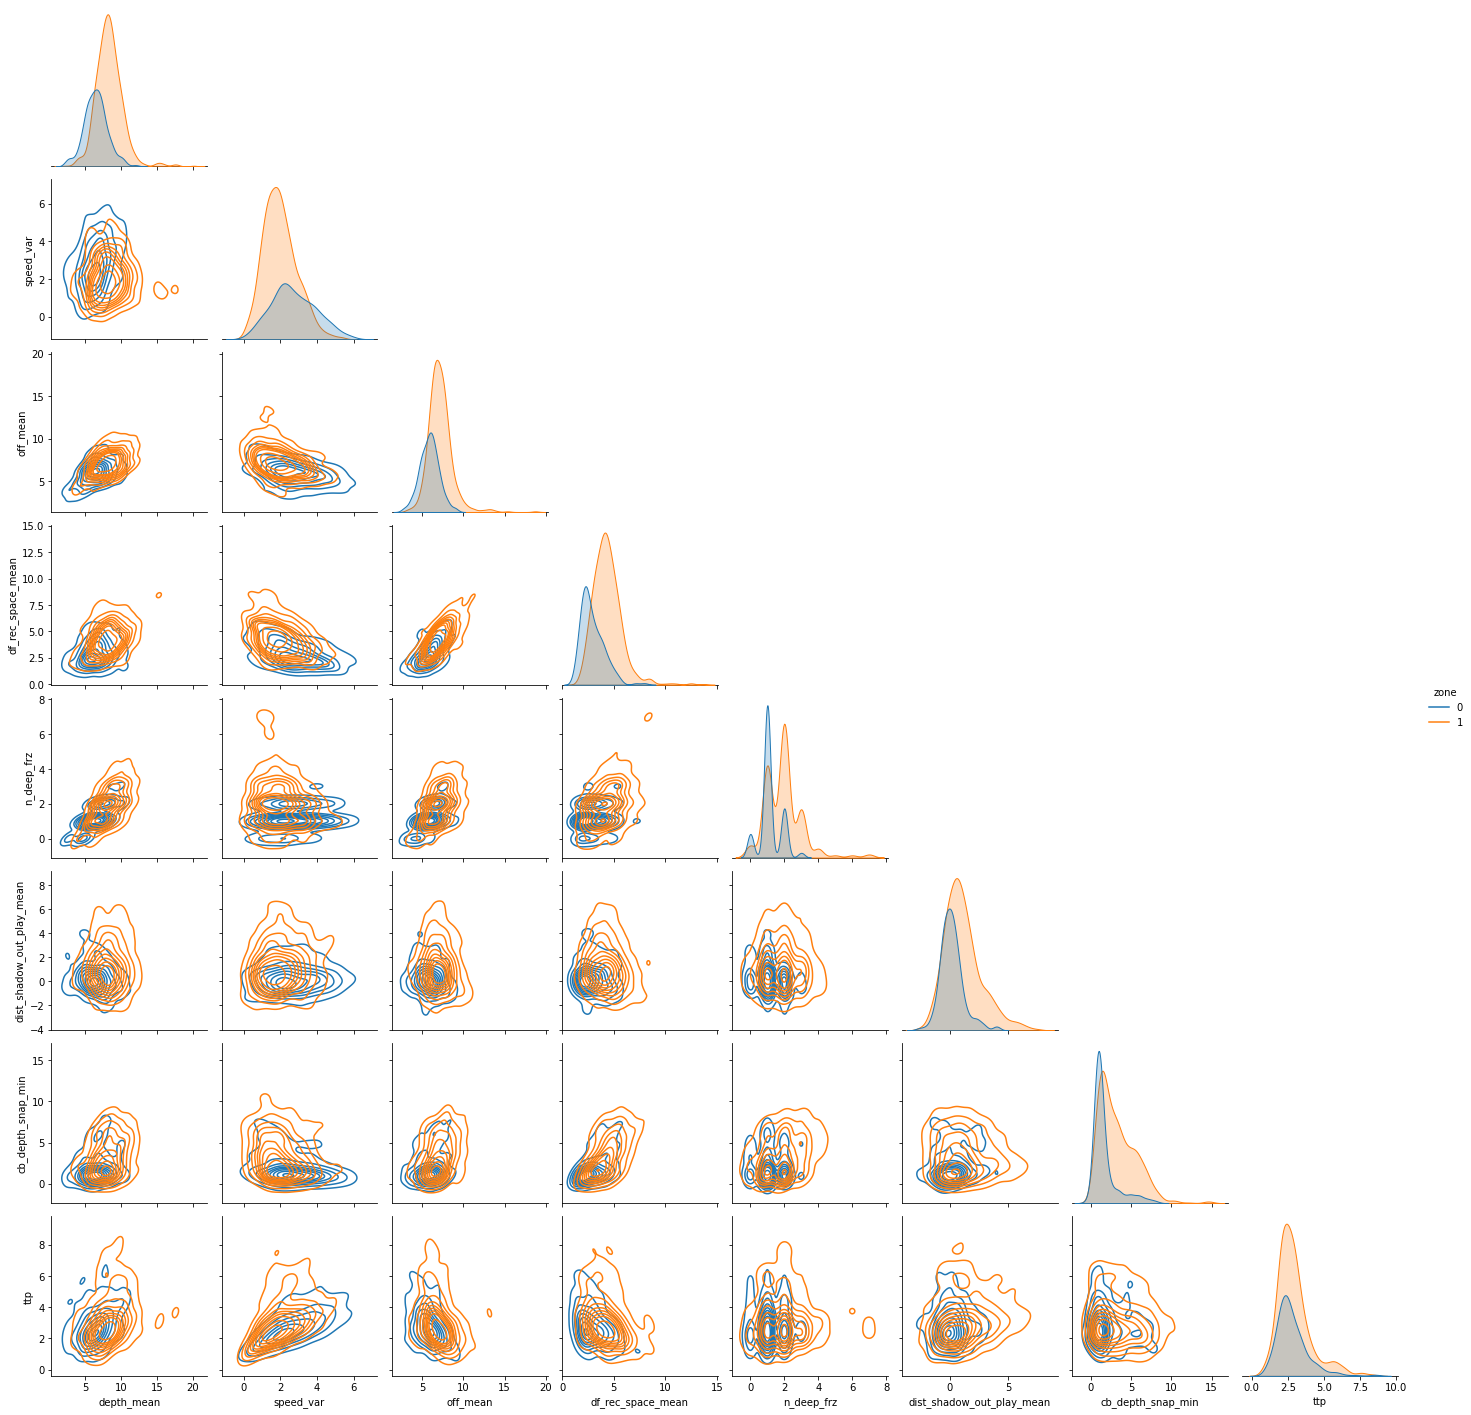

In [15]:
sns.pairplot(data=df, hue='zone', kind='kde', corner=True);

# SVC of simplified feature set

In [16]:
# build pipeline
estimators_svc = [('normalize', StandardScaler()),
              ('clf', SVC())]
pipe_svc = Pipeline(estimators_svc)

# build grid search
param_grid_svc = [
    {
        'clf': [LinearSVC(random_state=123456)],
#         'clf__penalty': ['l2'],
#         'clf__loss': ['hinge','squared-hinge'],
        'clf__class_weight': [None, 'balanced']
    },
    {
        'clf': [SVC(random_state=123456)],
        'clf__kernel': ['poly', 'rbf', 'sigmoid'],
    #     'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'clf__gamma': ['scale', 'auto'],
        'clf__class_weight': [None, 'balanced']
}]

# train model
clf_svcu = GridSearchCV(pipe_svc, param_grid=param_grid_svc, return_train_score=True)
clf_svcu.fit(X_train, y_train)
print(f'Train accuracy: {clf_svcu.cv_results_["mean_train_score"][clf_svcu.best_index_]:.3f}')
print(f'CV test accuracy: {clf_svcu.cv_results_["mean_test_score"][clf_svcu.best_index_]:.3f}')

Train accuracy: 0.848
CV test accuracy: 0.839


In [17]:
clf_svcu.best_params_

{'clf': LinearSVC(random_state=123456), 'clf__class_weight': None}

In [18]:
y_svcu_pred = clf_svcu.predict(X_test)
print(f'Test accuracy: {accuracy_score(y_test, y_svcu_pred):.3f}')
print(f'Test f1: {f1_score(y_test, y_svcu_pred):.3f}')
print()
print('Classification Report:')
print(classification_report(y_test, y_svcu_pred))
print()
print('Confusion Matrix: ')
pd.DataFrame(confusion_matrix(y_test, y_svcu_pred),
                   index=['Actual Man', 'Actual Zone'],
                   columns=['Pred. Man', 'Pred. Zone'])

Test accuracy: 0.825
Test f1: 0.874

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.66      0.71        68
           1       0.84      0.91      0.87       138

    accuracy                           0.83       206
   macro avg       0.81      0.78      0.79       206
weighted avg       0.82      0.83      0.82       206


Confusion Matrix: 


,Pred. Man,Pred. Zone
Actual Man,45,23
Actual Zone,13,125


## Confirm model will classify the "Prevent Zone" play as Zone

In [19]:
X_prevent = labeled_play_df_orig[labeled_play_df_orig.coverage=='Prevent Zone'].drop(columns=['gameId','playId','coverage','zone','cover'])
clf_svcu.predict(X_prevent)

array([1], dtype=int64)

# Test to make sure the model has reach stability based on number of samples to fit

In [20]:
n_samples = np.arange(50, 1001, 50)
n_cv = 5  # number of folds
cv_min = []
cv_avg = []
cv_max = []

for n in n_samples:
    # use subset of data
    subset_df = zone_df.sample(n=n, replace=False, random_state=123456)

    # get features and label for subset 
    y_sub = subset_df.zone
    X_sub = subset_df.drop(columns=['gameId', 'playId', 'coverage', 'zone', 'cover'])
    
    # set up classifier
    estimators_sub = [('normalize', StandardScaler()),
                      ('clf', LinearSVC(random_state=123456))]
    pipe_sub = Pipeline(estimators_sub)
    
    # calculate cross validation score
    cv = 5
    cv_scores = cross_val_score(pipe_sub, X_sub, y_sub, cv=n_cv)
    cv_min.append(np.min(cv_scores))
    cv_avg.append(np.mean(cv_scores))
    cv_max.append(np.max(cv_scores))

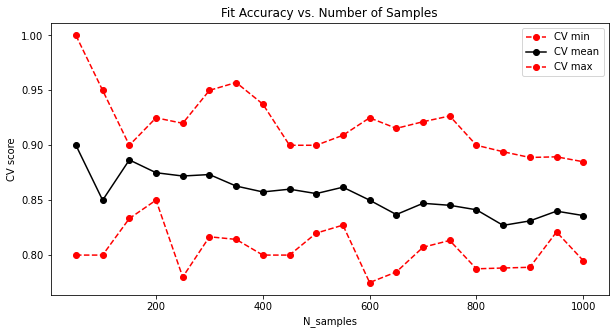

In [21]:
plt.figure(figsize=(10,5))
plt.plot(n_samples, cv_min, label='CV min', ls='--', marker='o', color='r')
plt.plot(n_samples, cv_avg, label='CV mean', ls='-', marker='o', color='k')
plt.plot(n_samples, cv_max, label='CV max', ls='--', marker='o', color='r')
plt.legend()
plt.xlabel('N_samples')
plt.ylabel('CV score')
plt.title('Fit Accuracy vs. Number of Samples');

# Save model

In [22]:
import joblib

In [23]:
# save the model for the best fit
joblib.dump(clf_svcu.best_estimator_, 'zone_classifier.joblib') 

['zone_classifier.joblib']

# ------ WORKSPACE -----------

In [24]:
# get predicted and actual man/zone for week 1, compare against teams
comp_df = zone_df[['gameId','playId','zone']].copy()
comp_df.rename(columns={'zone': 'zone_actual'}, inplace=True)
comp_df['zone_predict'] = clf_svcu.predict(X)
comp_df

,gameId,playId,zone_actual,zone_predict
0,2018090600,75,1,1
1,2018090600,146,1,1
2,2018090600,168,1,1
3,2018090600,190,1,1
4,2018090600,256,0,0
...,...,...,...,...
1023,2018091001,3787,1,1
1024,2018091001,3904,1,1
1025,2018091001,3928,1,1
1026,2018091001,3952,1,1


In [25]:
# get the teams involved in each play
temp = pd.merge(play_df[['gameId','playId','possessionTeam']], game_df[['gameId','homeTeamAbbr','visitorTeamAbbr','week']],
               on='gameId')
# get the defending team
temp['defendTeam'] = temp.apply(lambda x: x.homeTeamAbbr if (x.visitorTeamAbbr == x.possessionTeam) else x.visitorTeamAbbr, axis=1)
# save defending team in dataframe
defend_team_df = temp.drop(columns=['possessionTeam','homeTeamAbbr','visitorTeamAbbr'])
defend_team_df

,gameId,playId,week,defendTeam
0,2018090600,75,1,PHI
1,2018090600,146,1,PHI
2,2018090600,168,1,PHI
3,2018090600,190,1,PHI
4,2018090600,256,1,PHI
...,...,...,...,...
19234,2018122201,3931,16,BAL
19235,2018122201,3953,16,BAL
19236,2018122201,566,16,BAL
19237,2018122201,1719,16,BAL


In [26]:
# get the defensive team for each play of Week 1
week1_df = pd.merge(comp_df, defend_team_df, on=['gameId','playId'], how='left')
week1_df['correct_predict'] = (week1_df.zone_actual == week1_df.zone_predict).astype(int)
week1_df

,gameId,playId,zone_actual,zone_predict,week,defendTeam,correct_predict
0,2018090600,75,1,1,1,PHI,1
1,2018090600,146,1,1,1,PHI,1
2,2018090600,168,1,1,1,PHI,1
3,2018090600,190,1,1,1,PHI,1
4,2018090600,256,0,0,1,PHI,1
...,...,...,...,...,...,...,...
1022,2018091001,3787,1,1,1,OAK,1
1023,2018091001,3904,1,1,1,LA,1
1024,2018091001,3928,1,1,1,LA,1
1025,2018091001,3952,1,1,1,LA,1


In [27]:
week1_df.groupby('defendTeam').agg(
    count=pd.NamedAgg(column='gameId', aggfunc='count'),
    zone_actual=pd.NamedAgg(column='zone_actual', aggfunc='mean'),
    zone_predict=pd.NamedAgg(column='zone_predict', aggfunc='mean'),
    incorrect_predict=pd.NamedAgg(column='correct_predict', aggfunc=lambda x: 1 - x.mean())
).sort_values('incorrect_predict', ascending=False)

,count,zone_actual,zone_predict,incorrect_predict
defendTeam,,,,
GB,41,0.609756,0.707317,0.292683
CHI,41,0.512195,0.682927,0.268293
TB,47,0.723404,0.765957,0.255319
PHI,48,0.729167,0.812500,0.250000
HOU,43,0.697674,0.883721,0.232558
OAK,35,0.800000,0.742857,0.228571
NO,31,0.419355,0.322581,0.225806
MIA,38,0.657895,0.815789,0.210526
DAL,29,0.620690,0.413793,0.206897
